In [9]:
import torch
from skimage.io import imread
from torch.utils import data
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from time import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from dataloader import DataLoader
from losses import bce_loss, dice_loss, focal_loss
from network import EncDec, UNet

import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [10]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])


trainset = DataLoader(data_path="data", transform=train_transform, train=True)

testset = DataLoader(data_path="data", transform=test_transform, validation=True)

evalset = DataLoader(data_path="data", transform=test_transform)

# dataloader training
train_loader = data.DataLoader(dataset=trainset,
                                 batch_size=2,
                                 shuffle=True)
# dataloader validation
test_loader = data.DataLoader(dataset=testset,
                                   batch_size=2,
                                   shuffle=True)

# dataloader validation
eval_loader = data.DataLoader(dataset=evalset,
                                   batch_size=2)

x, y = next(iter(train_loader))

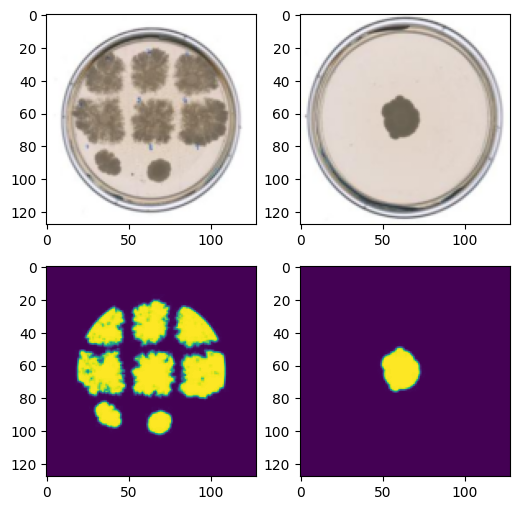

In [11]:
plt.rcParams['figure.figsize'] = [6, 6]

images, labels = next(iter(train_loader))

for i in range(2):
    plt.subplot(2, 2, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 2, i+3)
    plt.imshow(labels[i].squeeze())
plt.show()

In [12]:
print('Loaded %d training images' % len(trainset))
print('Loaded %d test images' % len(testset))
print('Loaded %d eval images' % len(evalset))

Loaded 144 training images
Loaded 36 test images
Loaded 19 eval images


In [13]:
def iou(target, prediction):
    intersection = torch.sum(torch.logical_and(target, prediction))
    union = torch.sum(torch.logical_or(target, prediction))
    return (intersection.item()/union.item())

def accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + FP + TN +FN)

def sensitivity(TP, FN):
    return TP / (TP + FN)

def specificity(TN, FP):
    return TN / (FP + TN) 

def dice(target, prediction):
    return 2 * torch.sum(torch.logical_and(target, prediction)) / (target.sum() + prediction.sum())

def compute_confusion(target, prediction):
    TP = torch.sum(torch.logical_and(prediction == 1, target == 1))
    TN = torch.sum(torch.logical_and(prediction == 0, target == 0))
    FP = torch.sum(torch.logical_and(prediction == 1, target == 0))
    FN = torch.sum(torch.logical_and(prediction == 0, target == 1))
                
    return TP.item(), TN.item(), FP.item(), FN.item()

In [14]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))
    out_dict = {'train_acc': [],
              'validation_acc': [],
              'train_loss': [],
              'validation_loss': []}

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        metrics = {
                    'iou': 0,
                    'accuracy': 0,
                    'sensitivity': 0,
                    'specificity': 0,
                    'dice': 0
                    }
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
            prediction = torch.where(F.sigmoid(Y_pred) > 0.5, 1, 0).detach().cpu()
            target = Y_batch.detach().cpu()
            
            TP, TN, FP, FN = compute_confusion(target, prediction)
            metrics['iou'] += iou(target, prediction) / len(train_loader)
            metrics['accuracy'] += accuracy(TP, TN, FP, FN) / len(train_loader)
            metrics['sensitivity'] += sensitivity(TP, FN) / len(train_loader)
            metrics['specificity'] += specificity(TN, FP) / len(train_loader)
            metrics['dice'] += dice(target, prediction) / len(train_loader)
            
        toc = time()
        out_dict["train_loss"].append(avg_loss.item())
        print(' - Train loss: %f' % avg_loss)
        
        

        avg_loss = 0
        metrics = {
                    'iou': 0,
                    'accuracy': 0,
                    'sensitivity': 0,
                    'specificity': 0,
                    'dice': 0
                    }
        model.eval()  # testing mode
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(test_loader)
            prediction = torch.where(F.sigmoid(Y_pred) > 0.5, 1, 0).detach().cpu()
            target = Y_batch.detach().cpu()
            
            TP, TN, FP, FN = compute_confusion(target, prediction)
            metrics['iou'] += iou(target, prediction) / len(test_loader)
            metrics['accuracy'] += accuracy(TP, TN, FP, FN) / len(test_loader)
            metrics['sensitivity'] += sensitivity(TP, FN) / len(test_loader)
            metrics['specificity'] += specificity(TN, FP) / len(test_loader)
            metrics['dice'] += dice(target, prediction) / len(test_loader)
            
        toc = time()
        out_dict["validation_loss"].append(avg_loss.item())
        print(' - Validation loss: %f' % avg_loss)
        print(f"IOU is {metrics['iou']}, accuracy is {metrics['accuracy']}, sensitivity is {metrics['sensitivity']}, specificity is {metrics['specificity']}, dice is {metrics['dice']}")
        
        
        
        # show intermediate results
        Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        print(f"IOU is {metrics['iou']}, accuracy is {metrics['accuracy']}, sensitivity is {metrics['sensitivity']}, specificity is {metrics['specificity']}, dice is {metrics['dice']}")
        
        
    return out_dict

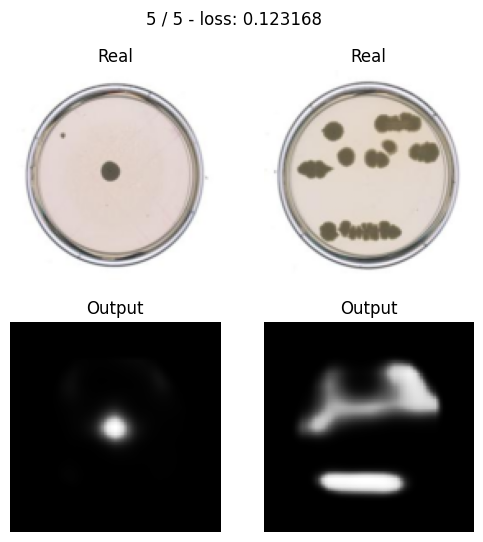

IOU is 0.3794980593385951, accuracy is 0.9907272187343025, sensitivity is 0.7253461754219906, specificity is 0.9949967042967226, dice is 0.808110237121582


In [15]:
model = EncDec().to(device)
# summary(model, (3, 256, 256))
out_dict = train(model, optim.Adam(model.parameters()), bce_loss, 5, train_loader, test_loader)

In [ ]:
#def predict(model, data):
#    model.eval()  # testing mode
#    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
#    return np.array(Y_pred)

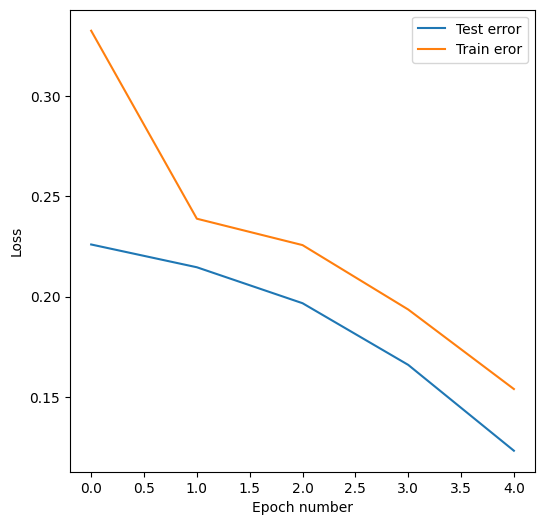

In [16]:
plt.plot(range(len(out_dict["validation_loss"])), out_dict["validation_loss"])
plt.plot(range(len(out_dict["train_loss"])), out_dict["train_loss"])
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

In [17]:
def bce_loss(y_real, y_pred):
    y_pred = torch.clip(y_pred, min=-10, max=10)
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [18]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    return 1 - (torch.mean(2*y_pred*y_real + 1) / (torch.mean(y_pred + y_real) + 1))

In [19]:
def focal_loss(y_real, y_pred):
    y_pred_s = torch.sigmoid(y_pred)
    return -torch.sum((((1-y_pred_s)**2) * y_real * torch.log(y_pred_s)) + ((1 - y_real) * torch.log(1-y_pred_s)))

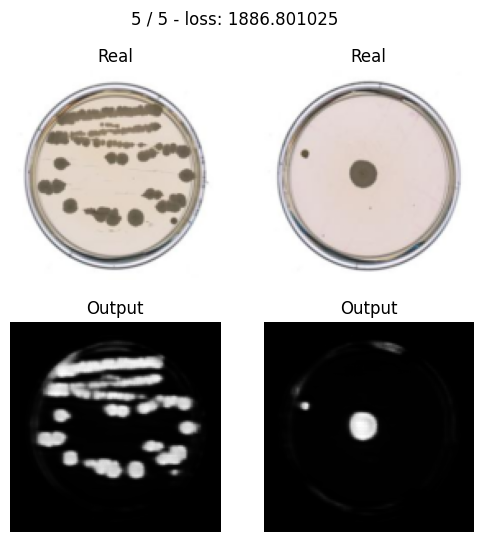

IOU is 0.33566486870751544, accuracy is 0.9886838780690322, sensitivity is 0.8611534345449484, specificity is 0.9935465370205833, dice is 0.7609239220619202


In [14]:
model = UNet().to(device)
out_dict = train(model, optim.Adam(model.parameters(), lr=1e-3), focal_loss, 5, train_loader, test_loader)

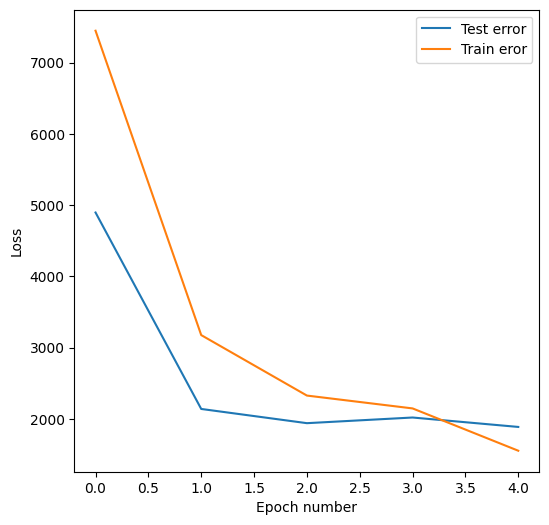

In [15]:
plt.plot(range(len(out_dict["validation_loss"])), out_dict["validation_loss"])
plt.plot(range(len(out_dict["train_loss"])), out_dict["train_loss"])
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

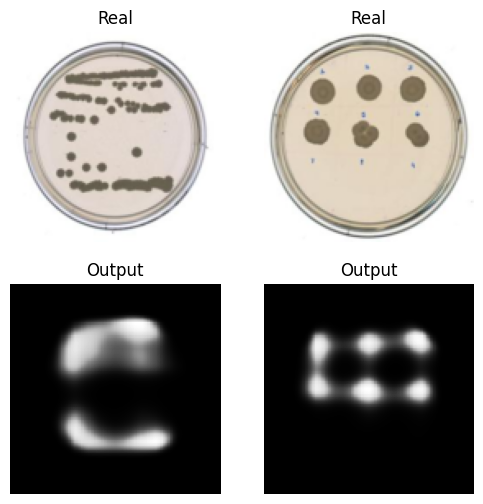

In [20]:
# show intermediate results
X_train, Y_train = next(iter(train_loader))
Y_hat = F.sigmoid(model(X_train.to(device))).detach().cpu()
clear_output(wait=True)
for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_train[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
# plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
plt.show()

# Shit about to go down

In [138]:
#import pickle

#with open('model.pickle', 'wb') as f:
#    pickle.dump(model, f)

In [21]:
import pickle

with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

In [22]:
def predict(model, data):
    model.eval()  
    Y_pred = [F.sigmoid(model(X.to(device))) for X, _ in data]
    return Y_pred

In [23]:
Y_pred = predict(model, eval_loader)

In [24]:
Y_pred_f = []

for i in range(len(Y_pred)):
    a = np.squeeze(Y_pred[i][0].detach().numpy())
    if i != len(Y_pred)-1 or len(evalset) % 2 == 0: 
        b = np.squeeze(Y_pred[i][1].detach().numpy())
        Y_pred_f.append(b)
    Y_pred_f.append(a)
Y_pred_f = np.asarray(Y_pred_f)

In [25]:
Y_true = [Y.to(device) for _, Y in eval_loader]

Y_true_f = []

for i in range(len(Y_true)):
    a = np.squeeze(Y_true[i][0].detach().numpy())
    if i != len(Y_pred)-1 or len(evalset) % 2 == 0: 
        b = np.squeeze(Y_pred[i][1].detach().numpy())
        Y_true_f.append(b)
    Y_true_f.append(a)

Y_true_f = np.asarray(Y_true_f)

In [139]:
#måske kommenter ud?
#Y_true_f = (Y_true_f > 0.5).astype(int)
#Y_pred_f = (Y_pred_f > 0.5).astype(int)

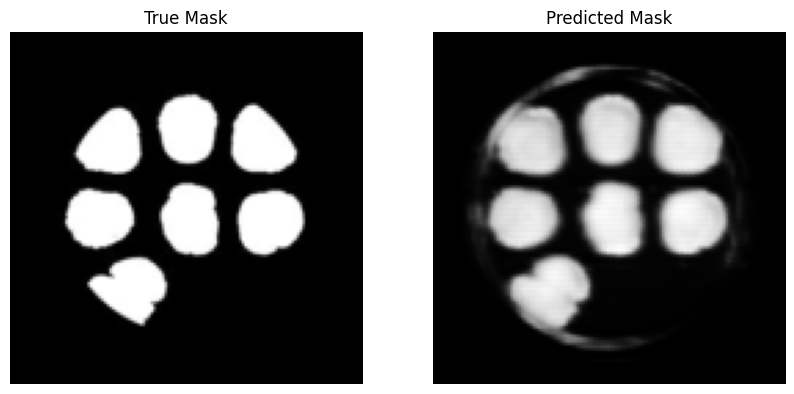

In [26]:

k = 15

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(Y_true_f[k], cmap='gray')
axs[0].set_title('True Mask')
axs[0].axis('off')

axs[1].imshow(Y_pred_f[k], cmap='gray')
axs[1].set_title('Predicted Mask')
axs[1].axis('off')

plt.show()

In [27]:
# Problem setup
n=10 # number of calibration points
alpha = 0.1 # 1-alpha is the desired false negative rate

def false_negative_rate(pred_masks, true_masks):
    return 1-((pred_masks * true_masks).sum(axis=1).sum(axis=1)/true_masks.sum(axis=1).sum(axis=1)).mean()

In [28]:
idx = np.array([1] * n + [0] * (Y_pred_f.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_sgmd, val_sgmd = Y_pred_f[idx,:], Y_pred_f[~idx,:]
cal_gt_masks, val_gt_masks = Y_true_f[idx], Y_true_f[~idx]

In [29]:
from scipy.optimize import brentq

# Run the conformal risk control procedure
def lamhat_threshold(lam): return false_negative_rate(cal_sgmd>=lam, cal_gt_masks) - ((n+1)/n*alpha - 1/(n+1))
lamhat = brentq(lamhat_threshold, 0, 1)
predicted_masks = val_sgmd >= lamhat

In [30]:
print(f"The empirical FNR is: {false_negative_rate(Y_pred_f, Y_true_f)} and the threshold value is: {lamhat}")

The empirical FNR is: 0.4207267761230469 and the threshold value is: 0.011818872298749604


In [31]:
#Y_true_f = (Y_true_f > 0.5).astype(int)
newY_pred_f = (Y_pred_f > lamhat).astype(int)

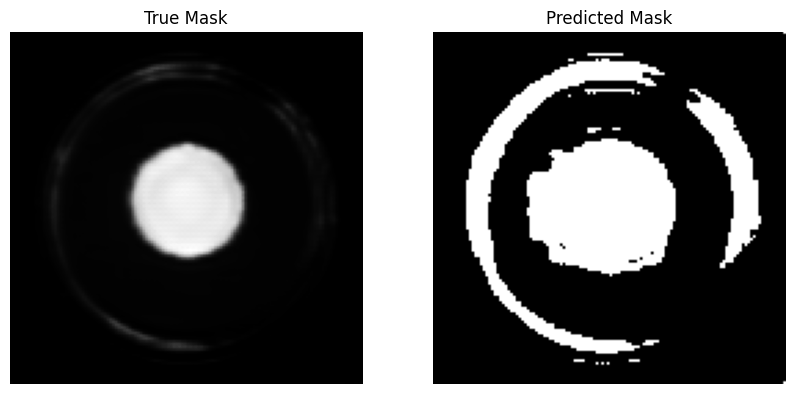

In [32]:
k = 4

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(Y_true_f[k], cmap='gray')
axs[0].set_title('True Mask')
axs[0].axis('off')

axs[1].imshow(newY_pred_f[k], cmap='gray')
axs[1].set_title('Predicted Mask')
axs[1].axis('off')

plt.show()